In [57]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from scipy.special import expit
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
import random as rnd 
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Num GPUs Available:  1
GPU is available


### Entendiendo ANN

**Circulo**

In [2]:
#Data
x1=np.random.uniform(-6,6,100000)
x2=np.random.uniform(-6,6,100000)
dat=pd.DataFrame(x1,columns=["x1"])
dat["x2"]=x2
dat["x1^2"]=x1**2
dat["x2^2"]=x2**2
dat["y"]=(dat["x1^2"]+dat["x2^2"]).apply(lambda x: 1 if x<=16 else 0)
dat.head()

,x1,x2,x1^2,x2^2,y
0,2.959109,1.640976,8.756327,2.692801,1
1,-4.788154,-0.759230,22.926421,0.576431,0
2,3.560848,3.899517,12.679637,15.206234,0
3,1.174224,-5.130675,1.378802,26.323826,0
4,-0.136122,3.548337,0.018529,12.590694,1


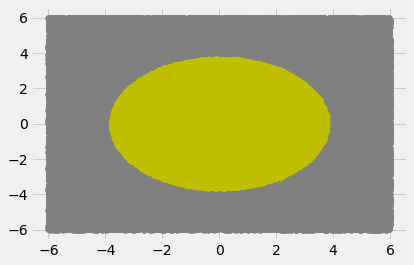

In [3]:
plt.style.use("fivethirtyeight")
plt.scatter(dat[dat["y"]==1]["x1"],dat[dat["y"]==1]["x2"], color="y")
plt.scatter(dat[dat["y"]==0]["x1"],dat[dat["y"]==0]["x2"],color="gray")

### ANN para modelar los puntos dentro(1) y fuera(0) del círculo

In [4]:
X=dat.drop("y",axis=1).values
y=dat["y"].values.reshape(-1,1)
X.shape

(100000, 4)

#### Función de activación

Sigmoide:
$$\sigma(w)=\frac{1}{1+e^{-w}}$$

 y su derivada $$\sigma{(w)}(1-\sigma(w))$$
 
 

In [5]:
def sigm(x):
    return expit(x)#(1/(1+np.exp(-x)))

def dsigm(x):
    x=sigm(x)
    return x*(1.0-x)

#### Arquitectura

In [6]:
def agunos(x):
    """
    Está función agrega el bias con una columna de 1's al principio
    
    input:
          array de mxn 
    output:
          array de (mx(n+1))
    """
    unos=np.ones((len(x),1))
    #print(unos.shape,x.shape)
    return np.concatenate([unos,x],axis=1)
agunos(X)[:3]

array([[ 1.        ,  2.95910915,  1.64097552,  8.75632697,  2.69280065],
       [ 1.        , -4.78815425, -0.75923027, 22.92642117,  0.5764306 ],
       [ 1.        ,  3.56084779,  3.89951718, 12.67963696, 15.20623422]])

Arquitectura NN Círculo


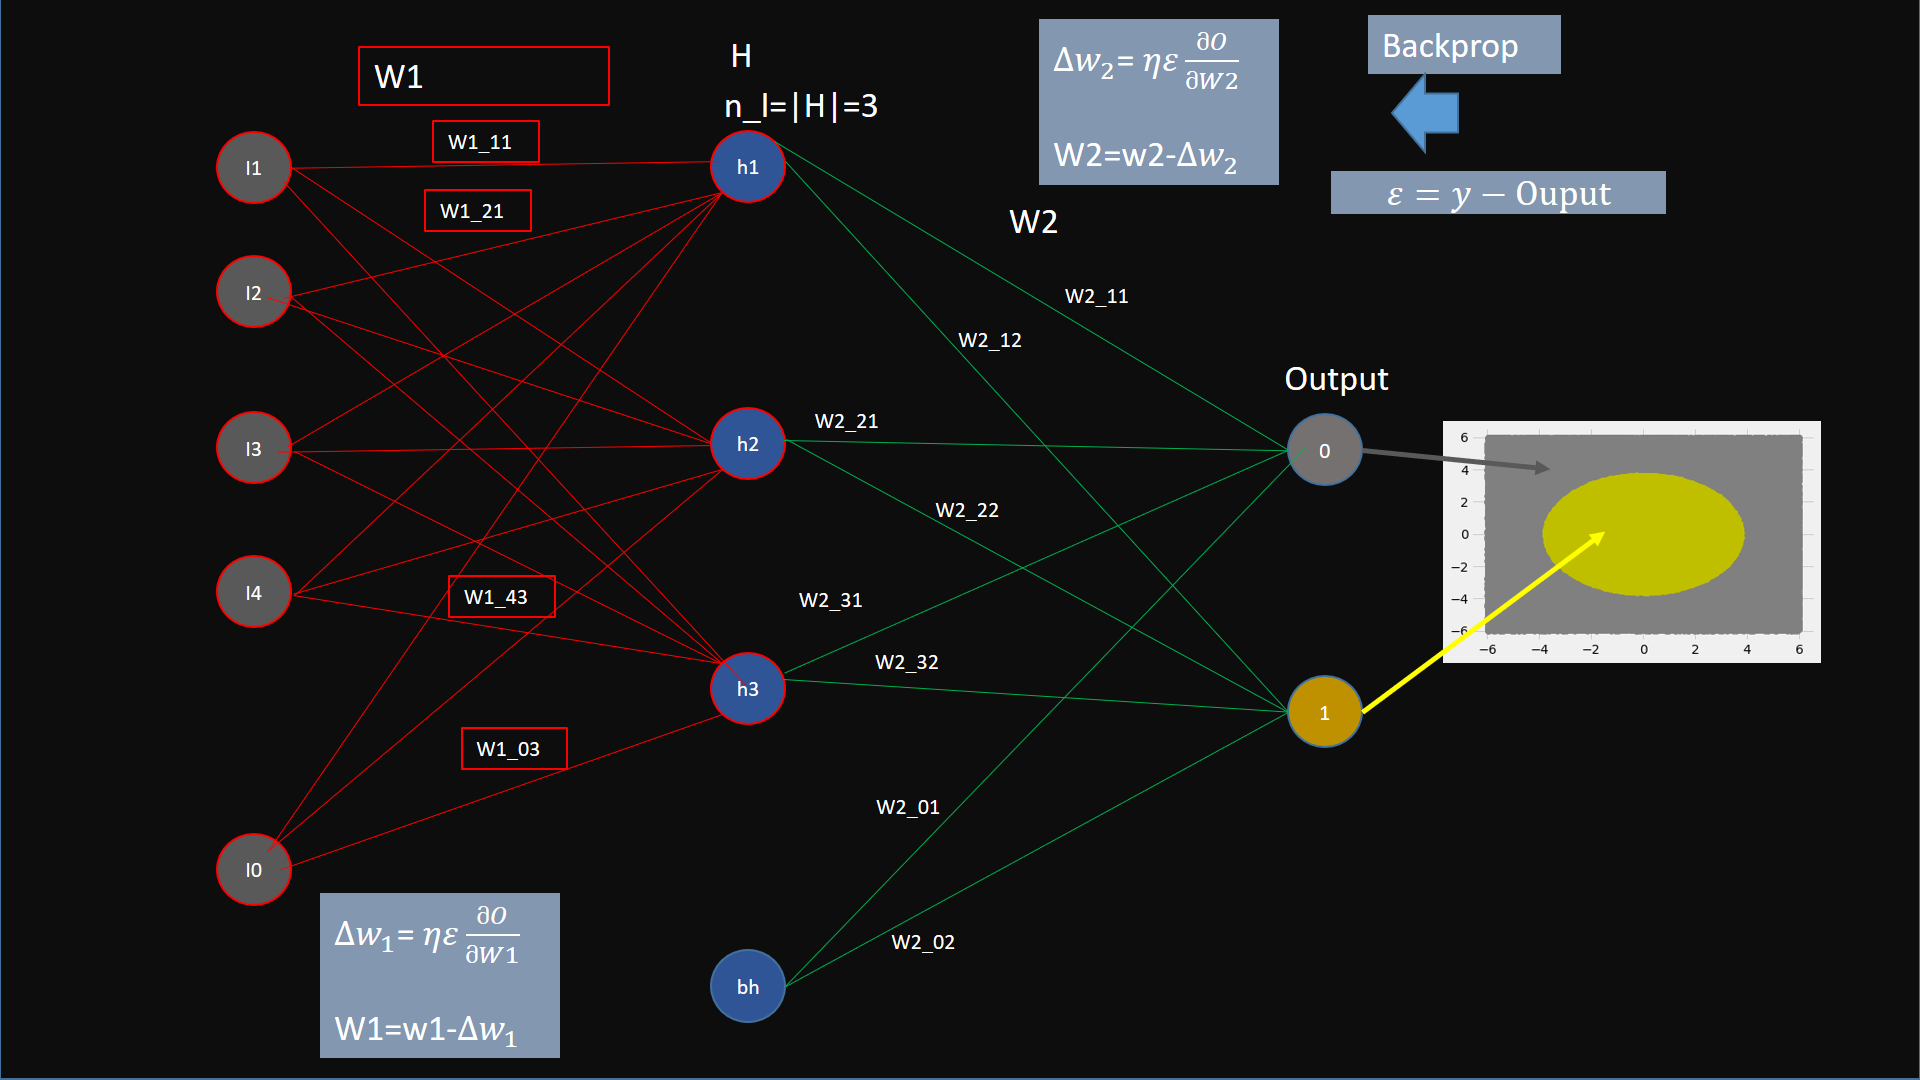

In [7]:
from IPython.display import Image
print("Arquitectura NN Círculo")
Image(filename='NN_circle.png')

$W1 \in \Re^{4x3}$                                     
$W2 \in \Re^{3x2}$

$I_{0} \in \Re^{3}$,
$b_{h} \in \Re^{2}$ 

$I=[I_{1},I_{2},I_{3},I_{4}]$

$O=[0,1]$


$H=[h_{1},h_{2},h_{3}]$: $$H=\sigma(I@W+I_{0}) \quad tal \quad que \quad h_{i}=\sigma({\sum_{j=0}^{4}I_{j}*W1_{ji}})\quad \forall i=1,2,3 \quad \textrm{j=0  es el bias} (I_{0})$$ 
$$O=\sigma(H@W2+bh)\quad tal\quad que\quad O_{k}=\sigma(\sum_{r=1}^{3}h_{r}*W2_{rk}+bh_{k}) \quad k=1,2 \quad con \quad O_{k}=0,1$$

Esto lo hacemos en código:

In [8]:
#número de neuronas en H
n_l=3
#num de outputs
out=2
#tasa de aprendizaje
eta=0.0001
#inicializar pesos
W1=np.random.uniform(-1,1,(X.shape[1]+1,3))
W2=np.random.uniform(-1,1,(n_l+1,out))

#inputs con bias
I=agunos(X)
z2=np.dot(I,W1)
#Armamos matricialmente:
H=agunos(sigm(z2))
z3=np.dot(H,W2)
O=sigm(z3)


In [9]:
O[:4]

array([[0.52143473, 0.82383578],
       [0.69271284, 0.69316209],
       [0.61780787, 0.83761684],
       [0.54361882, 0.72421768]])

#### Backpropagation

recordar el error $E(\mathbf{w})=1 / 2 \sum_{d \in M}\left(y-O\right)^{2}$, $\nabla E(\mathbf{w})=\left[\mathrm{d} E / \mathrm{d} \mathbf{w}_{\mathrm{o}}, \mathrm{d} \mathrm{E} / \mathrm{d} \mathbf{w}_{1}, \ldots, \mathrm{d} \mathrm{E} / \mathrm{d} \mathbf{w}_{\mathrm{n}}\right]$ queremos modificar los pesos en **dirección** donde más rápido se minimiza el error $-\nabla E(\mathbf{w})$.

Para ajustar los pesos:
$$\begin{array}{ll} 
& \mathrm{W}_{\mathrm{i}}=\mathrm{W}_{\mathrm{i}}+\Delta \mathrm{w}_{\mathrm{i}} \\
\text { donde } & \Delta \mathrm{w}_{\mathrm{i}}=-\eta \mathrm{d} \mathrm{E} / \mathrm{d} \mathrm{w}_{\mathrm{i}}
\end{array}$$

Para poder usar esta regla necesitamos calcular las derivadas parciales del error
Por lo tanto $$\begin{aligned}
&\begin{aligned}
\mathrm{dE} / \mathrm{d} \mathrm{w}_{\mathrm{i}}=& \mathrm{d} / \mathrm{d} \mathrm{w}_{\mathrm{i}} 1 / 2\left(\mathrm{V}_{\mathrm{ent}}-\mathrm{g}\right)^{2} \\
&=\left(\mathrm{V}_{\mathrm{ent}}-\mathrm{g}\right) \mathrm{d} / \mathrm{d} \mathrm{w}_{\mathrm{i}}\left(\mathrm{V}_{\text {ent }}-\mathrm{g}\right) \\
&=\left(\mathrm{V}_{\mathrm{ent}}-\mathrm{g}\right)\left(-\mathrm{d} / \mathrm{d} \mathrm{w}_{\mathrm{i}}(\mathrm{g})\right)
\end{aligned}\\
&\text { Por lo tanto }\\
&\Delta \mathrm{w}_{\mathrm{i}}=\eta\left(y-\mathrm{O}\right) \mathrm{d} / \mathrm{d} \mathrm{w}_{\mathrm{i}}(\mathrm{O})
\end{aligned}$$

esto es para las neuronas de salida, para las intermedias tenemos:
$$\begin{aligned}
&\mathrm{E}_{\mathrm{h}}=\sigma_{\mathrm{h}}\left(1-\sigma_{\mathrm{h}}\right) \sum \mathrm{w}_{\mathrm{kh}} \mathrm{E}_{\mathrm{k}}, \text { donde } \mathrm{k} \text { son las neuronas de la etapa }\\
&\text { siguiente }
\end{aligned}$$

In [10]:
Err=O-y
#este es para actualizar los pesos de W1
#d2 es en este caso Eh
d2=np.dot(Err,W2.T)*dsigm(agunos(z2))
d2=d2[:,1:]#no usamos la 1ra. columna xq es la del bias y no está conectada con las neuronas anteriores.

**Mapeo de notación**

np.dot(Err,W2.T)$_{h}=\sum \mathrm{w}_{\mathrm{kh}} \mathrm{E}_{\mathrm{k}}$ en este caso k son los outpus ([0,1]) 

dsigm(agunos(z2))$_{h}=\sigma_{\mathrm{h}}\left(1-\sigma_{\mathrm{h}}\right)$ 

$z_{2}=I@W1$

np.dot(I.T,d2)$_{ji}=E_{j} x_{ji}$

np.dot(H.T,Err)$=(y-\mathrm{O}) \mathrm{d} / \mathrm{d} \mathrm{w}_{\mathrm{i}}(\mathrm{O})$ en este último paso recordar que  	$\frac{\partial O}{\partial w2}=\frac{\partial (W2@H+bh)}{\partial w2}=H$  

y dado lo anterior quién es $\frac{\partial O}{\partial w1}?$ por la regla de la cadena sabemos que:
$$\frac{\partial O}{\partial w1}=\frac{\partial O}{\partial H}\frac{\partial H}{\partial w1}=W2*\frac{\partial \sigma(W1@I)}{\partial w1}$$ y esto justifica el calculo de d2.

Lo quue podemos deducir es que $\Delta w_{ij}= \eta*Err * \frac{\partial O}{\partial w_{ij}}$

Para cada neurona j y peso $\mathrm{w}_{\text {ji }}$
$$
w_{j i}<- w_{j i}+\eta E_{j} x_{ji}
$$
donde $x_{j i}$ es la entrada a la neurona j de la neurona i y $w_{j i}$ es el peso de esa conexión

In [11]:
#gradiente para w1
grad1=np.dot(I.T,d2)
#gradiente para W2
grad2=np.dot(H.T,Err)
print(grad1.shape,grad2.shape)

(5, 3) (4, 2)


In [12]:
#actualizamos w's
W1-=eta*grad1
W2-=eta*grad2

### Implementando Backpropagation

In [34]:
%%time
out=1
epochs=10000 #número de entrenamientos...
#inicializamos pesos
W1=np.random.uniform(-1,1,(X.shape[1]+1,3))
W2=np.random.uniform(-1,1,(n_l+1,out))
acc=[]
ll=[]
#inputs con bias
for i in range(epochs):
    I=agunos(X)
    z2=np.dot(I,W1)
    #Armamos matricialmente:
    H=agunos(sigm(z2))
    z3=np.dot(H,W2)
    O=sigm(z3)
    Err=O-y
    #este es para actualizar los pesos de W1
    #d2 es en este caso Eh
    d2=np.dot(Err,W2.T)*dsigm(agunos(z2))
    d2=d2[:,1:]#no usamos la 1ra. columna xq es la del bias y no está conectada con las neuronas anteriores.
    #gradiente para w1
    grad1=np.dot(I.T,d2)
    #gradiente para W2
    grad2=np.dot(H.T,Err)
    #print(grad1.shape,grad2.shape)
    #actualizamos w's
    W1-=eta*grad1
    W2-=eta*grad2
    
    acc.append(np.sum(pred==y)/len(y))
    ll.append(0.5*np.sum((y-O)**2))
    pred=np.round(O,0)
    if i%1000==0:
        print(f"Loss:{0.5*np.sum((y-O)**2)},accuracy:{np.sum(pred==y)/len(y)}")

Loss:14422.44800346742,accuracy:0.40237
Loss:2369.3255654052236,accuracy:0.94609
Loss:1674.064535583027,accuracy:0.95988
Loss:1690.1875550082304,accuracy:0.95363
Loss:1725.1197198343511,accuracy:0.95139
Loss:737.6289278983718,accuracy:0.97223
Loss:957.9209117889199,accuracy:0.96752
Loss:339.382663155395,accuracy:0.99026
Loss:198.73948842185405,accuracy:0.99413
Loss:442.4542748649718,accuracy:0.98443
Wall time: 8min 40s


In [35]:
print(classification_report(y,pred))
print(confusion_matrix(y,pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     65096
           1       0.94      1.00      0.97     34904

    accuracy                           0.98    100000
   macro avg       0.97      0.98      0.98    100000
weighted avg       0.98      0.98      0.98    100000

[[63051  2045]
 [    0 34904]]


In [36]:
dat['pred']=pred

Text(0.5, 1.0, 'Predicciones verde->dentro rojo->fuera')

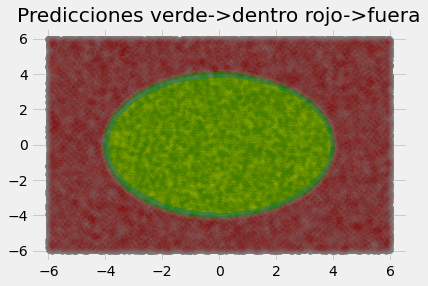

In [37]:
plt.scatter(dat[dat["y"]==1]["x1"],dat[dat["y"]==1]["x2"], color="y")
plt.scatter(dat[dat["y"]==0]["x1"],dat[dat["y"]==0]["x2"],color="gray")

plt.scatter(dat[dat["pred"]==1]["x1"],dat[dat["pred"]==1]["x2"], color="green",alpha=.02,marker='*')
plt.scatter(dat[dat["pred"]==0]["x1"],dat[dat["pred"]==0]["x2"],color="r",alpha=.009)

plt.title("Predicciones verde->dentro rojo->fuera")

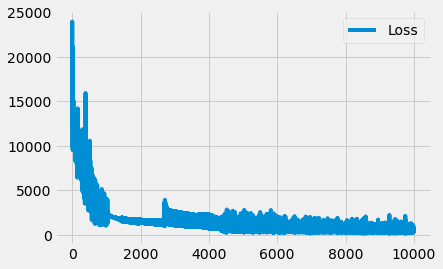

In [39]:
plt.plot(range(10000),ll,label="Loss")
#plt.plot(range(10000),acc,label="accuracy")
plt.legend()
plt.show()

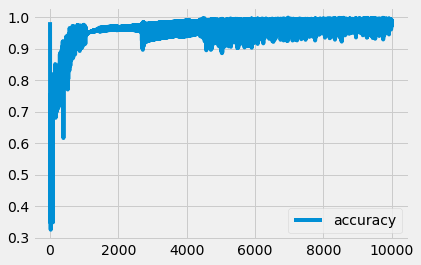

In [40]:
plt.plot(range(10000),acc,label="accuracy")
plt.legend()
plt.show()

### ANN Con TF

In [88]:
out=1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
x=tf.placeholder(tf.float32,shape=[None,X.shape[1]])
y_=tf.placeholder(tf.int32,shape=[None,out])

In [89]:
#inicializando pesos y biases
w1=tf.Variable(tf.random.uniform([X.shape[1],n_l],-1,1),name="w1")
w2=tf.Variable(tf.random.uniform([n_l,out]),name="w2")
b1=tf.Variable(tf.zeros([n_l]),name="b1")
b2=tf.Variable(tf.zeros([out]),name="b2")

En Tensorflow vamos a representar $$H=\sigma(x@w1+b1)\quad b1 \in \Re^{n_l}$$ y $$Z=\sigma(H@w2+b2) \quad b2 \in \Re^{out}$$

In [90]:
H=tf.sigmoid(tf.matmul(x,w1)+b1)
Z=tf.sigmoid(tf.matmul(H,w2)+b2)

Función de costo en este caso es binary_cross_entropy que es la correcta para tareas de clasificación

$$loss_{fn}=-\sum_{i=0}^{n} ylog(Z)+(1-y)log(1-Z)$$

usamos el métod de gradiente desc para minimizar la función y hacer el backpropagation como en el primer ejemplo.

In [91]:
#binary cross entropy
loss_fn=tf.reduce_mean(-1*(tf.cast(y_,dtype=tf.float32)*tf.log(Z)+tf.cast(1-y_,dtype=tf.float32)*tf.log(1.0-Z)))
#entrenamineto con backpropagation gradiente desc
train_step=tf.train.GradientDescentOptimizer(.01).minimize(loss_fn)

In [92]:
init=tf.initialize_all_variables() 
sess=tf.Session()


In [93]:
%%time
#entrenamiento 10000 epochs
sess.run(init)
loss_f=[]
accur=[]
for i in range(50000):
    sess.run(train_step,feed_dict={x:X,y_:y})
    loss=sess.run(loss_fn,feed_dict={x:X,y_:y})
    preds=np.round(sess.run(Z,feed_dict={x:X,y_:y}),0)
    if i%1000==0:
        print(f"loss:{loss},acc:{accuracy_score(y,preds)}")
    loss_f.append(loss)
    accur.append(accuracy_score(y,preds))

loss:0.9800300598144531,acc:0.34706
loss:0.5699262619018555,acc:0.70341
loss:0.522701621055603,acc:0.77369
loss:0.4810347557067871,acc:0.81628
loss:0.42979398369789124,acc:0.85327
loss:0.34454143047332764,acc:0.89493
loss:0.272102415561676,acc:0.93038
loss:0.2137557864189148,acc:0.95841
loss:0.1749272644519806,acc:0.97196
loss:0.15128517150878906,acc:0.97745
loss:0.13400690257549286,acc:0.98136
loss:0.12072894722223282,acc:0.98413
loss:0.11022689193487167,acc:0.98623
loss:0.10172297060489655,acc:0.98797
loss:0.09469874203205109,acc:0.98952
loss:0.0887974351644516,acc:0.9905
loss:0.08376683294773102,acc:0.99132
loss:0.07942435145378113,acc:0.99227
loss:0.07563476264476776,acc:0.99286
loss:0.07229599356651306,acc:0.99337
loss:0.06932973861694336,acc:0.99382
loss:0.0666746273636818,acc:0.99426
loss:0.0642823651432991,acc:0.99464
loss:0.062114112079143524,acc:0.99502
loss:0.060138341039419174,acc:0.99528
loss:0.058329373598098755,acc:0.99555
loss:0.056665897369384766,acc:0.9958
loss:0.0551

**Observamos los resultados parecidos al entrenamiento usando numpy, podemos entonces mostrar la equivalencia de lo que hace tensoflow usando el ejercicio en el punto 3 con la diferencia de las funciones de pérdida y costo.**

In [94]:
preds=np.round(sess.run(Z,feed_dict={x:X,y_:y}),0)
print(classification_report(y,preds))
print(confusion_matrix(y,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65294
           1       1.00      1.00      1.00     34706

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

[[65294     0]
 [  169 34537]]


In [95]:
dat['predtf']=preds

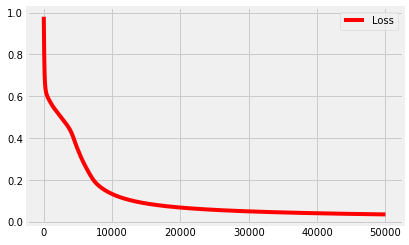

In [97]:
plt.plot(range(50000),loss_f,label="Loss",color="r")
#plt.plot(range(10000),acc,label="accuracy")
plt.legend()
plt.show()

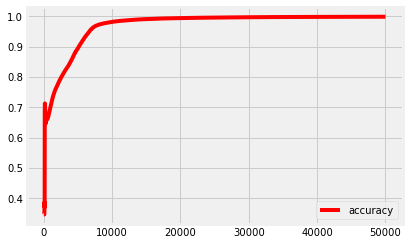

In [98]:
plt.plot(range(50000),accur,label="accuracy",color="r")
plt.legend()
plt.show()

#### Resultados tensorflow

Text(0.5, 1.0, 'Predicciones TF azul->dentro morado->fuera')

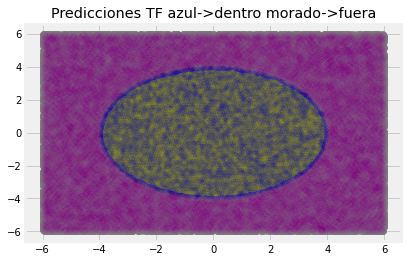

In [99]:
plt.scatter(dat[dat["y"]==1]["x1"],dat[dat["y"]==1]["x2"], color="y")
plt.scatter(dat[dat["y"]==0]["x1"],dat[dat["y"]==0]["x2"],color="gray")

plt.scatter(dat[dat["predtf"]==1]["x1"],dat[dat["predtf"]==1]["x2"], color="b",alpha=.02,marker='*')
plt.scatter(dat[dat["predtf"]==0]["x1"],dat[dat["predtf"]==0]["x2"],color="purple",alpha=.009)

plt.title("Predicciones TF azul->dentro morado->fuera")

### Conclusiones

Fully conected NN no es otra cosa que hacer multiplicación de matrices de inputs y outputs de cada capa oculta  a estas multiplicaciones se les aplica una función de activación  en estos ejemplos sigmoides o logísticas.

En el tema de aprendizaje el objetivo es encontrara las $W's$ que minimizan la función de error correspondiente, lo que siginifica que queremos saber quien es $\frac{dE}{d w_{ij}}$ y para calcular esta derivada cuando $w_{ij}$ es un peso de capas intermedias $\frac{dE}{d w_{ij}}=\frac{dE}{d O}\frac{dO}{d H}\frac{dH}{d w_{ij}}...$  este proceso es llamado backpropagation  con estas derivadas se actualizan los pesos hasta que se minimiza la función de costos(Fradiente descendente).